# Reading in data

In [ ]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
features = pd.read_csv('/content/sf-data-summary-inserted-v2.csv')
features.tail(3)

,Date,Day,Month,Year,House_Price_Index(S&P/Case-Shiller),Mortgage_Rate (30 yers),Personal_Income,Resident_Population,Unemployment_Rate,GDP,Crime_Rate,Percent_With_Mortgage_Debt,Median_Debt,Percent_With_Severely_Delinquent_Debt,New_Structures,Economic_Conditions_Index,CPI all items less shelter
152,11/1/2017,1,11,2017,252.430756,3.92,99057.50,4723.99850,2.9,556510.944,714.631992,0.3450,375758.6667,0.005,1372,4.82,236.108
153,12/1/2017,1,12,2017,255.294023,3.95,99646.75,4725.15625,2.8,559333.354,715.003000,0.3440,376057.0000,0.005,2004,4.95,236.108
154,1/1/2018,1,1,2018,258.569765,4.03,100236.00,4726.31400,3.1,562155.764,712.993958,0.3453,375355.6667,0.005,933,5.02,240.742


In [ ]:
days = features['Day']
months = features['Month']
years = features['Year']

# Creating train and test sets

In [ ]:
import numpy as np

# Use numpy to convert to arrays
# Labels are the values we want to predict
labels = np.array(features['House_Price_Index(S&P/Case-Shiller)'])
dates = np.array(features['Date'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('House_Price_Index(S&P/Case-Shiller)', axis = 1)
features= features.drop('Date', axis = 1)
features= features.drop('Day', axis = 1)
features= features.drop('Year', axis = 1)
features= features.drop('Month', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)
#features[143][0]

In [ ]:
#creating train and test sets
train_features = features[:143,:]
test_features = features[143:,:]
train_labels = labels[:143]
test_labels = labels[143:]

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (143, 12)
Training Labels Shape: (143,)
Testing Features Shape: (12, 12)
Testing Labels Shape: (12,)


# Creating a random forest regressor, training, and testing it

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
#trying out a regressor with different hyperparameters
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1) 

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2)) #omg wait that's not a lot of error I think

Mean Absolute Error: 11.61


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') #woah that is quite accurate....

Accuracy: 95.33 %.


# Visualizing one decision tree

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

In [ ]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 13


# Variable importance

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Percent_With_Severely_Delinquent_Debt Importance: 0.97
Variable: Median_Debt          Importance: 0.01
Variable: Mortgage_Rate (30 yers) Importance: 0.0
Variable: Personal_Income      Importance: 0.0
Variable: Resident_Population  Importance: 0.0
Variable: Unemployment_Rate    Importance: 0.0
Variable: GDP                  Importance: 0.0
Variable: Crime_Rate           Importance: 0.0
Variable: Percent_With_Mortgage_Debt Importance: 0.0
Variable: New_Structures       Importance: 0.0
Variable: Economic_Conditions_Index Importance: 0.0
Variable: CPI all items less shelter Importance: 0.0


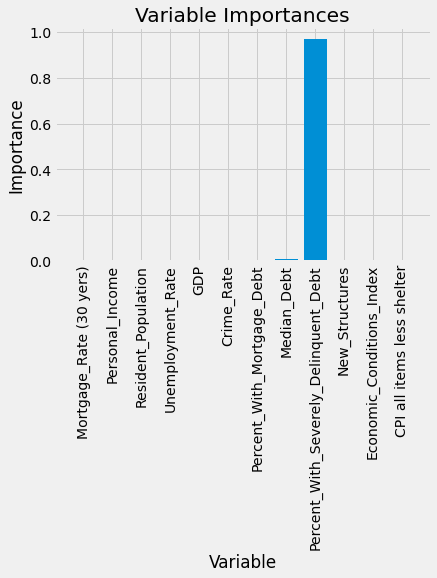

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('Mortgage_Rate (30 yers)'), feature_list.index('Percent_With_Severely_Delinquent_Debt')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.') #still seem like quite good results omg

Mean Absolute Error: 13.35
Accuracy: 94.62 %.


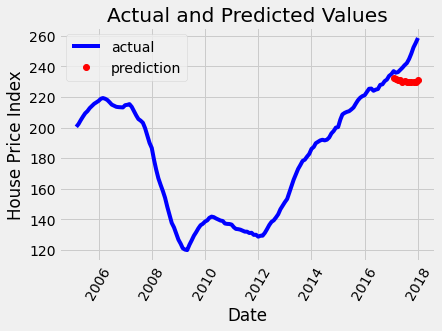

In [ ]:
# Use datetime for creating date objects for plotting
import datetime

# Dates of training values
m1 = months
d1 = days
y1 = years

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y1, m1, d1)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
m2 = months[143:]
d2 = days[143:]
y2 = years[143:]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(y2, m2, d2)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('House Price Index'); plt.title('Actual and Predicted Values');